In [206]:
from numpy.random import seed
seed(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import *
from collections import namedtuple
import Metrics
from PatientSet import PatientSet
from Constants import Constants
from Clustering import *
import re

#sklearn dependencies
from sklearn.metrics import roc_auc_score, adjusted_rand_score
from sklearn.utils import resample
from sklearn.cluster import FeatureAgglomeration

#we get like a million deprication errors for some reason with the external libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [214]:
#plotting parameter
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
FIG_SIZE = (20,15)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=FIG_SIZE)

In [2]:
#load in the patientset object that has all the patient info
db = PatientSet()

#add a bunch of features to the object that we'll want to try
#so we can use the db.to_dataframe function to get them all in a nice dataframe with one-hot encoding and labels automatically
db.t_volumes = np.array([np.sum([g.volume for g in gtvs]) for gtvs in db.gtvs]).reshape(-1,1)
db.bilateral = db.lateralities == 'B'
db.total_volumes = db.volumes.sum(axis = 1)
db.toxicity = db.feeding_tubes + db.aspiration > 0
db.tsimdoses = tsim_prediction(db)

D:\git_repos\CAMP-RT\PYTHON\Patient.py:360: RuntimeWarning: invalid value encountered in true_divide
  mean_tumor_distances /= tumor_volume
D:\git_repos\CAMP-RT\PYTHON\Patient.py:361: RuntimeWarning: invalid value encountered in true_divide
  tumor_position /= tumor_volume


error reading tumor volume for  10091
error reading tumor volume for  10148
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

patient data loaded...



In [174]:
%load_ext autoreload
%autoreload 2
from Clustering import *

#parameters for the experiments
toxicities_to_test = ['toxicity']

#features to test the feature selection on.  should be fields in the patientset we have
#we don't cluster on these
unclusterable_features = ['t_volumes', 'bilateral', 'total_volumes']
#we cluster on these (each individually) if feature_clustering is defined,
clusterable_features = ['tumor_distances', 'volumes']

#features specifically for feature selection vs actually using.  Should either be
#some combo of actual and predicted dose for this
true_features = ['doses']
predicted_features = ['tsimdoses']

#number of times to resample and doing feature selection
#if n = 1, just use the first result
n_samples = 20

rescale = False
df_rescale = lambda d: (d - d.min(axis = 0))/(d.max(axis =0) - d.min(axis=0))

#put some bounds on the features to subset
min_features = 2

#for now just constrain it to one cluster
n_clusters = 2
selection_clusterer  = FClusterer(n_clusters)
cluster_feature_selector = FeatureClusterSelector(
    n_samples = n_samples,
    clusterer = selection_clusterer)
lg_feature_selector = FeatureSelector(n_samples = n_samples)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
true, predicted = get_train_test_datasets(db, 
                                      unclusterable_features, 
                                      clusterable_features, 
                                      true_features, 
                                      predicted_features)

In [175]:
cluster_importances = cluster_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
cluster_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
0,0.615843,0.950445,0.999996,0.999999,0.999926,0.796441,0.970252,0.843097,1.000000,0.999531,...,0.000000,0.757369,0.999989,0.840000,4.206207e-01,0.999136,0.414168,0.170776,0.000000,0.000000
1,0.542518,0.696269,0.333798,0.996458,0.999304,0.983315,0.969113,0.997897,0.919111,0.909884,...,0.000000,0.303998,0.614762,0.982362,9.754353e-01,0.790000,0.962202,0.522243,0.850000,0.995444
2,0.268336,0.525198,0.447561,1.000000,0.999717,0.998860,0.914790,0.999619,0.988356,0.999556,...,0.795784,0.968949,0.658719,0.975075,0.000000e+00,0.936522,0.000000,0.993639,0.825000,0.968139
3,0.947841,0.573313,0.775000,0.975075,0.998695,0.000000,0.888215,0.999930,0.999994,0.674418,...,0.737469,0.690137,0.998693,0.639196,0.000000e+00,0.998318,0.900617,0.999606,0.696533,0.000000
4,0.951483,0.619156,0.945271,0.479351,0.993169,0.998924,1.000000,0.980896,0.996922,0.992689,...,0.290094,0.878105,0.927797,0.780000,1.110223e-16,0.460794,0.000000,0.997618,0.747638,0.000000


In [176]:
lg_importances = lg_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
lg_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
0,0.497874,0.541098,0.729719,0.675108,0.685348,0.663203,0.561626,0.699738,0.728795,0.723936,...,0.507706,0.550142,0.687300,0.261961,0.527490,0.663132,0.568952,0.761302,0.240091,0.561653
1,0.675762,0.662245,0.518090,0.687708,0.631515,0.645938,0.581564,0.755394,0.716704,0.768686,...,0.525915,0.426406,0.654302,0.280892,0.607212,0.583030,0.316531,0.743750,0.258528,0.540220
2,0.652941,0.652100,0.647358,0.689524,0.679825,0.707486,0.586533,0.699381,0.698289,0.535645,...,0.498698,0.218040,0.659107,0.217300,0.470659,0.592157,0.483510,0.722812,0.265625,0.541943
3,0.556790,0.728906,0.667199,0.602325,0.659151,0.751119,0.512508,0.707131,0.719216,0.680014,...,0.506316,0.437686,0.578627,0.224888,0.659668,0.642261,0.637195,0.762112,0.562331,0.609427
4,0.336760,0.728543,0.823103,0.717500,0.779705,0.770851,0.571138,0.657957,0.636726,0.735781,...,0.483889,0.492969,0.566902,0.321987,0.569383,0.609295,0.487792,0.610362,0.000000,0.542982


In [198]:

top_n_importances = lambda x, n: x.mean().sort_values(ascending = False).iloc[0:n]
def plot_n_importances(x, n):
    x = x.reindex(x.mean().sort_values(ascending=False).index, axis = 'columns')
    x = x.iloc[:,0:n]
    xmin = x.mean().min()
    xoffset = x - xmin*.99
    xoffset.mean().plot.barh(left=xmin*.99, **{'xerr': x.std().values/n_samples})

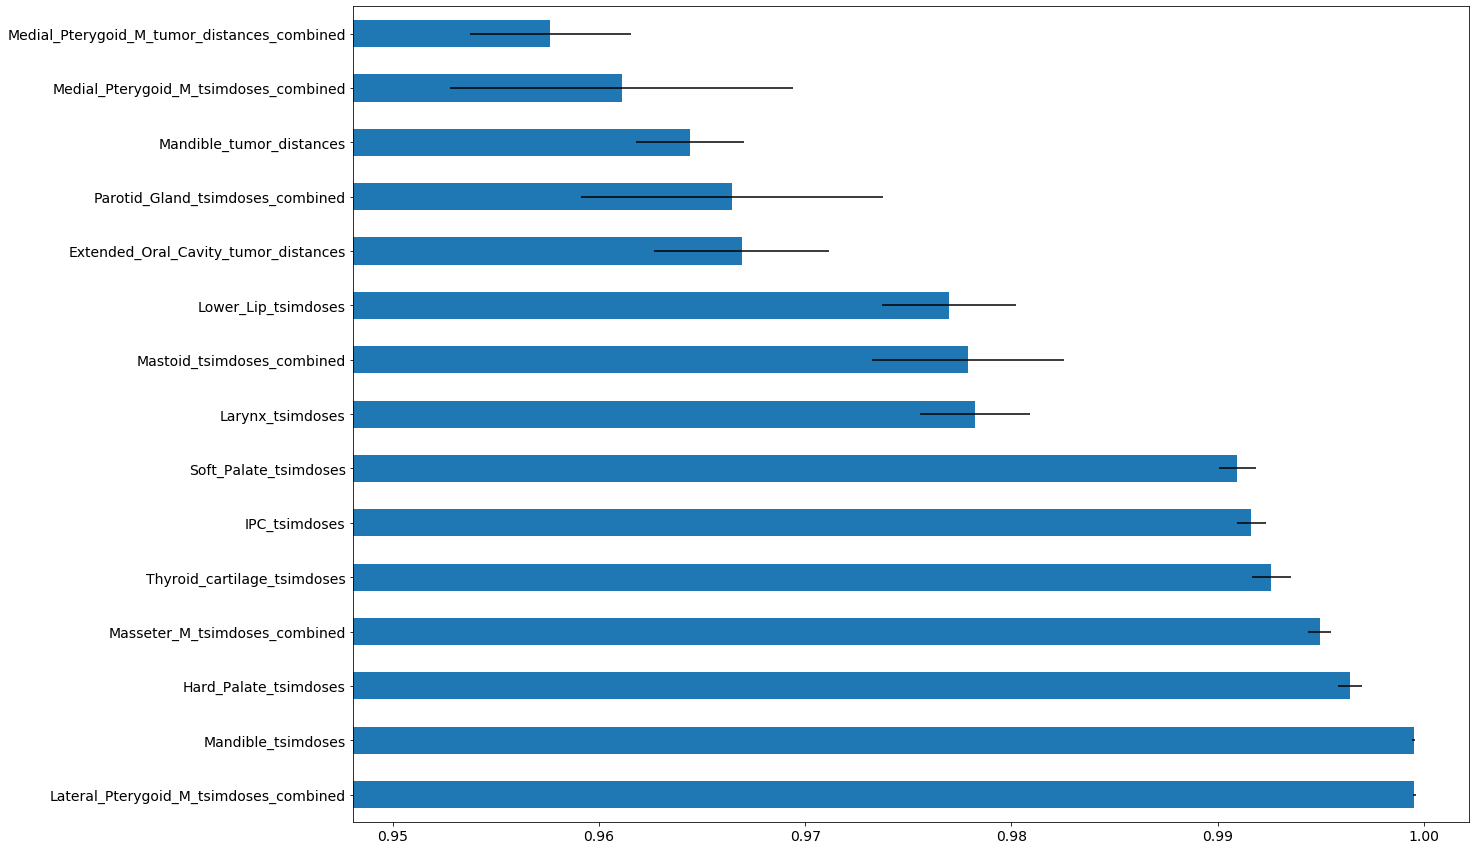

In [215]:
plot_n_importances(cluster_importances, 15)

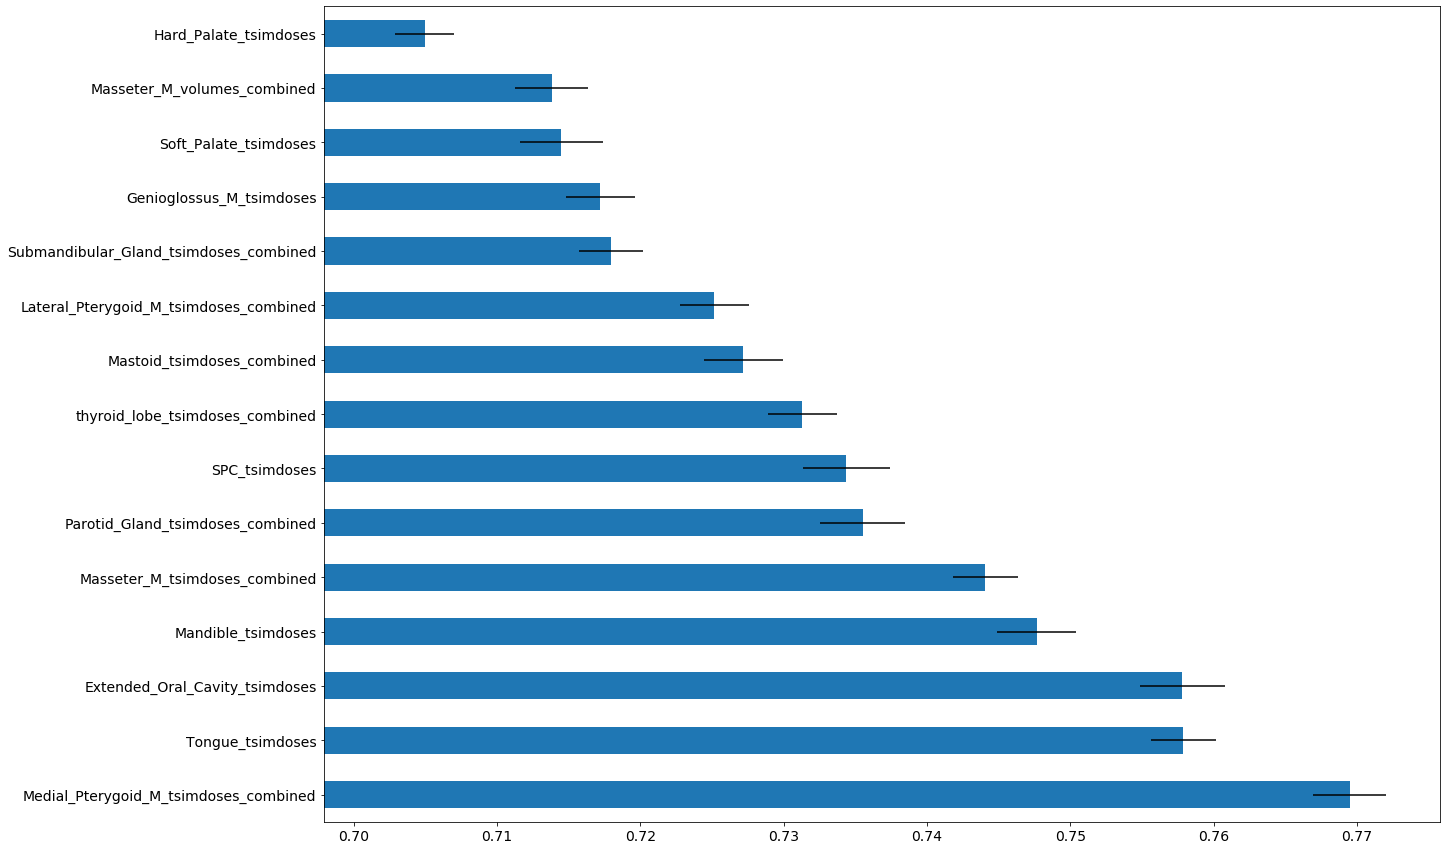

In [216]:
plot_n_importances(lg_importances,15)

In [226]:
lg_importances.total_volumes.mean()

0.6137231360880361